---

# <center> ML Aplicada - Detecção de spam em emails 

---

<img src="./spam.png" width="300"/>

---

### Descrição:

O conceito de spam é diverso: anúncios de produtos/sites, esquemas para ganhar dinheiro rápido (pirâmides), correntes, pornografia...

O conjunto de dados, retirado do repositório UCI ML, contém cerca de 4.600 e-mails rotulados como **spam** ou **ham**.

Observações:
Essa coleção de e-mails de spam veio de postmaster e de indivíduos que enviaram spam. A coleção de e-mails não-spam veio de e-mails pessoais e de trabalho arquivados e, portanto, a palavra "george" e o código de área "650" são indicadores de não-spam. 

Eles são úteis ao construir um filtro de spam personalizado. Seria necessário ocultar esses indicadores não-spam ou obter uma coleção muito ampla de não-spam para gerar um filtro de spam de uso geral.


### Objetivos:
- Compreender o conjunto de dados e limpeza (se necessário).
- Construir modelos de classificação para prever se o email é spam ou não.
- Ajustar os hiperparâmetros e comparar as métricas de avaliação de vários algoritmos de classificação.

---

**Etapas para tratar a tarefa:**
1. Exploração dos dados
2. Análise exploratória dos dados
3. Pré-processamento dos dados
4. Manipulações dos dados (aumento sintético de dados, por exemplo)
5. Extraçlão e seleção de atributos
6. Modelagem preditiva

---

# <center>1. Exploração dos dados

In [1]:
import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE # -> técnica para aumento sintético de dados
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor # -> análise de variância para redução de dimensionalidade

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [2]:
# Importando o dataset

df = pd.read_csv('./Spam.csv')

target = 'spam'
labels = ['Ham','Spam']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mDescrição:\033[0m O banco de dados possui {} atributos & {} amostras.'.format(df.shape[1], df.shape[0]))

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,...,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,...,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1



Descrição: O banco de dados possui 58 atributos & 4601 amostras.


In [3]:
# Checando o tipo das variáveis

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

In [4]:
# Verificando o número de linhas exclusivas em cada recurso

df.nunique().sort_values()

spam                             2
word_freq_table                 38
word_freq_3d                    43
word_freq_parts                 53
word_freq_font                  99
word_freq_conference           106
word_freq_857                  106
word_freq_cs                   108
word_freq_415                  110
word_freq_receive              113
word_freq_addresses            118
word_freq_direct               125
word_freq_telnet               128
word_freq_report               133
word_freq_original             136
word_freq_over                 141
word_freq_make                 142
word_freq_money                143
word_freq_order                144
word_freq_credit               148
word_freq_lab                  156
word_freq_people               158
word_freq_technology           159
word_freq_project              160
word_freq_pm                   163
word_freq_000                  164
word_freq_internet             170
word_freq_address              171
word_freq_remove    

In [5]:
# Verificando o número de atributos categóricos e numéricos

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; # atributos categóricos e numéricos

for i in range(df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mDescrição:\033[0m O banco de dados possui {} atributos numéricos & {} categóricos.'.format(len(nf),len(cf)))


Descrição: O banco de dados possui 57 atributos numéricos & 0 categóricos.


In [6]:
# Verificando as estatísticas de todas as colunas

#display(df.describe())
df.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,...,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,0.059824,0.541702,0.093930,0.058626,0.049205,0.248848,0.142586,0.184745,1.662100,0.085577,0.809761,0.121202,0.101645,0.094269,0.549504,...,0.047835,0.105412,0.097477,0.136953,0.013201,0.078629,0.064834,0.043667,0.132339,0.046099,0.079196,0.301224,0.179824,0.005444,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,0.201545,0.861698,0.301036,0.335184,0.258843,0.825792,0.444055,0.531122,1.775481,0.509767,1.200810,1.025756,0.350286,0.442636,1.671349,...,0.329445,0.532260,0.402623,0.423451,0.220651,0.434672,0.349916,0.361205,0.766819,0.223812,0.621976,1.011687,0.911119,0.076274,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.310000,0.000000,0.220000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,0.000000,0.800000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,2.640000,0.000000,1.270000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

---

# <center> 2. Análise de dados exploratória

           Distribuição da variável alvo           


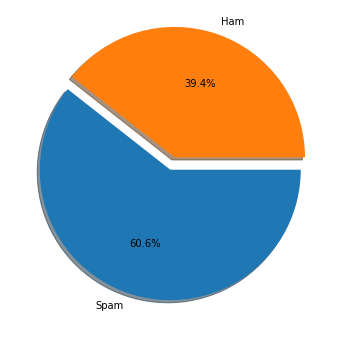

In [7]:
# Vamos primeiro analisar a distribuição da variável alvo

MAP={}
for e, i in enumerate(df[target].unique()):
    MAP[i]=labels[e]

df1 = df.copy()
df1[target]=df1[target].map(MAP)
explode=np.zeros(len(labels))
explode[-1]=0.1
print('\033[1mDistribuição da variável alvo'.center(55))
plt.pie(df1[target].value_counts(), labels=df1[target].value_counts().index, counterclock=False, shadow=True, 
        explode=explode, autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

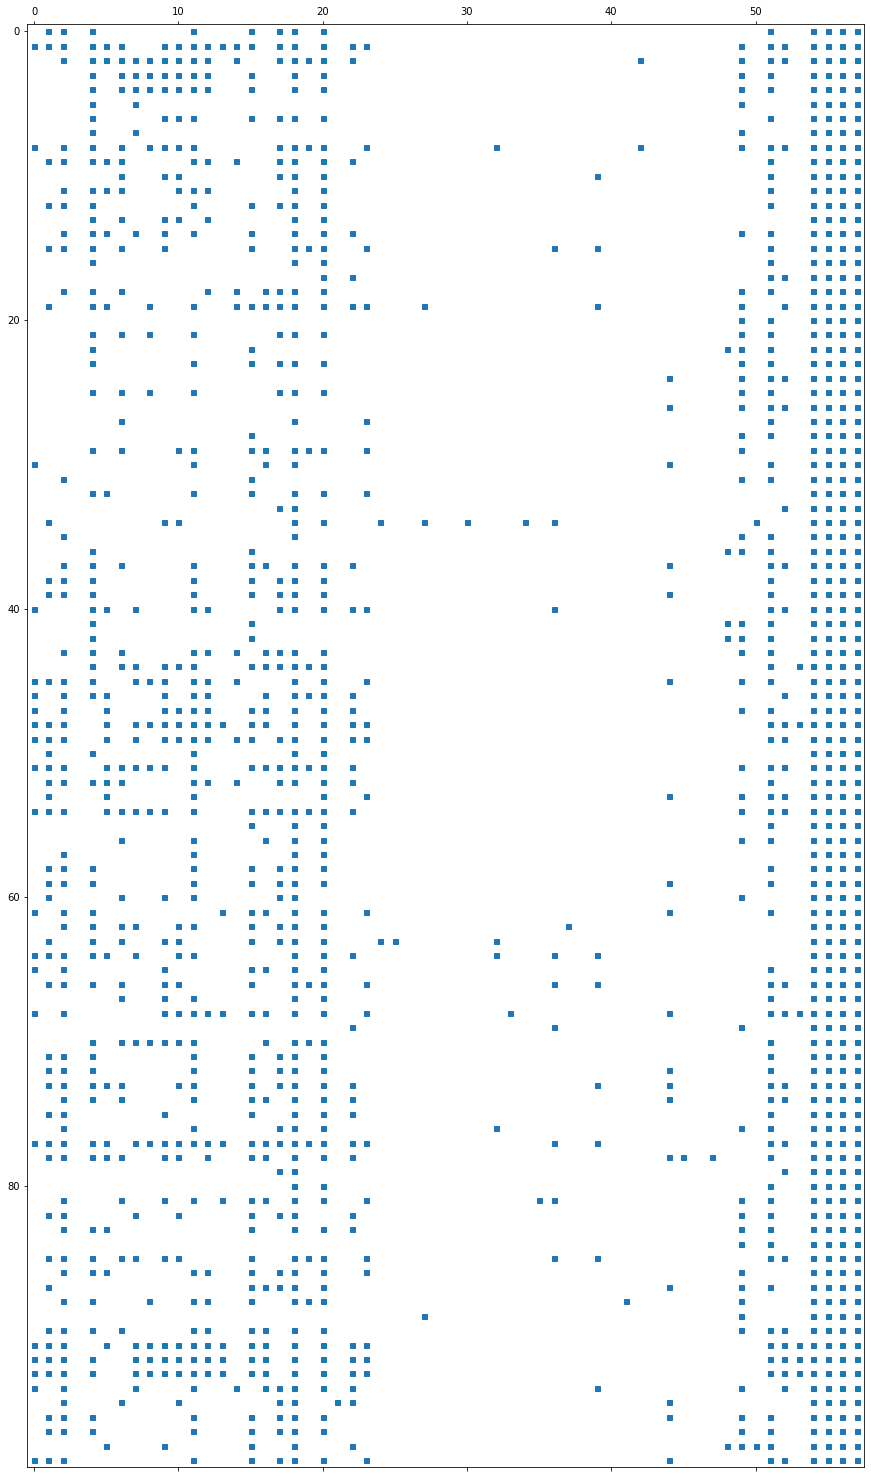

In [8]:
# Visualizando alguns dados em uma matriz esparsa
# Pontos azuis representam valores > 0

plt.figure(figsize=[15,30])
plt.title('')
plt.spy(df[:100].values, precision = 0.1, markersize = 5)
plt.show()

---

# <center> 3. Pré-processamento dos dados

In [9]:
# Remoção de quaisquer linhas duplicadas (se houver)

counter = 0
r,c = original_df.shape

df1 = df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInfo:\033[0m O banco de dados não possui duplicadas')
else:
    print(f'\n\033[1mInfo:\033[0m Número de duplicadas removidas ---> {r-df1.shape[0]}')


Info: Número de duplicadas removidas ---> 391


In [10]:
# Checando por elementos vazios/valores ausentes

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total de valores nulos'])
nvc['porcentagem'] = round(nvc['Total de valores nulos']/df1.shape[0],3)*100
print(nvc)

                            Total de valores nulos  porcentagem
word_freq_make                                   0          0.0
word_freq_857                                    0          0.0
word_freq_data                                   0          0.0
word_freq_415                                    0          0.0
word_freq_85                                     0          0.0
word_freq_technology                             0          0.0
word_freq_1999                                   0          0.0
word_freq_parts                                  0          0.0
word_freq_pm                                     0          0.0
word_freq_direct                                 0          0.0
word_freq_cs                                     0          0.0
word_freq_meeting                                0          0.0
word_freq_original                               0          0.0
word_freq_project                                0          0.0
word_freq_re                            

In [11]:
xtrain,xtest, ytrain, ytest = train_test_split(df1.drop([target],axis=1), df1[target], \
                                               test_size=0.2, random_state=0)

# Podemos utilizar o kfold estratificado para melhorar a distribuição de classes

In [12]:
nzero = np.count_nonzero(np.array(ytrain))
zero = xtrain.shape[0]-nzero
print(nzero, zero)

1332 2036


In [13]:
xtrain.shape

(3368, 57)

In [14]:
# Corrigindo o desbalanceamento de classes usando a técnica SMOTE -> 
# -> apenas para o conjunto de TREINAMENTO

#df5 = df1.copy()

print('Distribuição original das classes:')
print('0:',zero, ' \n1:',nzero)

xf = df1.columns
X = xtrain
Y = ytrain

smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

#df5 = pd.DataFrame(X, columns=xf)
#df5[target] = Y

print('\nDistribuição das classes após a aplicação do SMOTE:',)
print(Y.value_counts())

Distribuição original das classes:
0: 2036  
1: 1332

Distribuição das classes após a aplicação do SMOTE:
1    2036
0    2036
Name: spam, dtype: int64


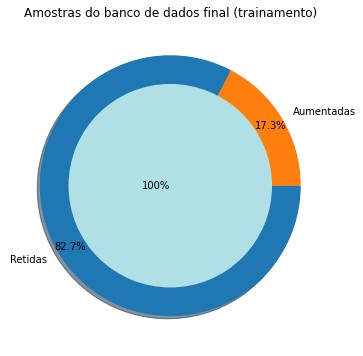


Info:O banco de dados final após a limpeza possui possui 57 atributos & 3368 amostras.


In [15]:
# Tamanho final do conjunto de dados após realizar o pré-processamento

plt.title('Amostras do banco de dados final (trainamento)')

plt.pie([xtrain.shape[0], zero-nzero], radius=1, shadow=True,\
        labels=['Retidas','Aumentadas'], counterclock=False, \
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0])

plt.pie([xtrain.shape[0]], labels=['100%'], labeldistance=-0, \
        radius=0.78, shadow=True, colors=['powderblue'])
plt.show()

print('\n\033[1mInfo:\033[0mO banco de dados final após a limpeza possui possui {} atributos & {} amostras.'.format(xtrain.shape[1], xtrain.shape[0]))

---

# <center> 4. Manipulação dos dados

In [16]:
# Dividindo os dados em conjuntos de treinamento e teste

#df = df5.copy()
#df.columns=[i.replace('[','_') for i in df.columns]

#X = df.drop([target],axis=1)
#Y = df[target]
#Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

Train_X, Test_X, Train_Y, Test_Y = xtrain, xtest, ytrain, ytest

print('Original: ',X.shape,Y.shape,'\nTreinamento: ',Train_X.shape,Train_Y.shape,'\nTeste: ', Test_X.shape,'', Test_Y.shape)

Original:  (4072, 57) (4072,) 
Treinamento:  (3368, 57) (3368,) 
Teste:  (842, 57)  (842,)


In [17]:
std = StandardScaler()

print('\033[1mNormalização no conjunto de treinamento'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mNormalização no conjunto de teste'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                            Normalização no conjunto de treinamento                             


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,...,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,...,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03,3.368000e+03
mean,-3.059047e-17,-1.054844e-18,9.704562e-17,5.274219e-19,5.063250e-17,1.265812e-17,2.109687e-17,-1.265812e-17,2.531625e-17,8.227781e-17,-4.008406e-17,1.687750e-17,-2.689852e-17,-2.531625e-17,1.054844e-17,3.797437e-17,3.480984e-17,5.274219e-17,8.016812e-17,3.164531e-18,-5.274219e-17,-3.375500e-17,1.687750e-17,2.109687e-17,-1.213070e-17,...,1.687750e-17,1.054844e-17,1.002102e-17,-9.493594e-18,2.953562e-17,-8.438750e-18,1.371297e-17,2.320656e-17,-1.582266e-17,2.689852e-17,3.164531e-18,-2.637109e-17,-7.383906e-18,1.872348e-17,-2.109687e-17,1.793234e-17,3.797437e-17,-3.586469e-17,6.592773e-18,3.164531e-18,3.480984e-17,2.320656e-17,-6.329062e-18,1.476781e-17,3.006305e-17
std,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,...,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00,1.000148e+00
min,-3.541558e-01,-2.419718e-01,-5.640803e-01,-5.011513e-02,-4.696880e-01,-3.396818e-01,-2.934884e-01,-2.604592e-01,-3.214289e-01,-4.115517e-01,-3.044621e-01,-6.331685e-01,-3.065492e-01,-1.879666e-01,-1.888595e-01,-3.265516e-01,-3.309788e-01,-3.513484e-01,-9.788230e-01,-1.622129e-01,-7.068298e-01,-1.232899e-01,-2.884195e-01,-2.165759e-01,-3.489096e-01,...,-1.726025e-01,-1.555765e-01,-1.972965e-01,-2.630001e-01,-3.363318e-01,-6.077079e-02,-1.900132e-01,-1.951717e-01,-1.279137e-01,-1.794186e-01,-2.068578e-01,-1.249605e-01,-3.081766e-01,-2.041528e-01,-7.189412e-02,-1.166248e-01,-1.588462e-01,-5.023987e-01,-1.568087e-01,-4.056484e-01,-3.035972e-01,-1.229341e-01,-1.252112e-01,-2.400416e-01,-4.890235e-01
25%,-3.541558e-01,-2.419718e-01,-5.640803e-01,-5.011513e-02,-4.696880e-01,-3.396818e-01,-2.934884e-01,-2.604592e-01,-3.214289e-01,-4.115517e-01,-3.044621e-01,-6.331685e-01,-3.065492e-01,-1.879666e-01,-1.888595e-01,-3.265516e-01,-3.309788e-01,-3.513484e-01,-9.788230e-01,-1.622129e-01,-7.068298e-01,-1.232899e-01,-2.884195e-01,-2.165759e-01,-3.489096e-01,...,-1.726025e-01,-1.555765e-01,-1.972965e-01,-2.630001e-01,-3.363318e-01,-6.077079e-02,-1.900132e-01,-1.951717e-01,-1.279137e-01,-1


                                Normalização no conjunto de teste                                


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,...,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,...,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000
mean,0.021796,0.027205,0.076307,-0.041190,0.037852,-0.024091,-0.031765,0.023636,-0.024835,0.032680,0.010518,-0.033717,0.005631,0.050031,-0.052616,0.035289,0.015770,-0.030686,-0.018589,0.013609,0.006328,-0.026740,0.036859,0.049310,-0.029841,...,0.026841,-0.022983,0.029195,-0.057733,-0.015112,0.018137,0.016365,-0.017169,0.033239,-0.035285,-0.021312,0.009489,-0.003698,0.000618,0.010988,-0.047828,0.002862,-0.029543,-0.014746,0.123030,-0.016196,0.060480,0.011623,-0.009257,0.013931
std,1.144678,0.987832,1.117733,0.169944,1.043898,0.756143,0.844759,1.036384,0.850387,1.451401,0.979720,0.884487,0.864952,1.504305,0.802532,1.221944,1.120647,0.946768,1.018249,0.903409,1.023311,0.780213,1.154364,1.331528,1.007982,...,0.947675,0.976698,0.991929,0.882761,0.928429,1.213294,1.142816,0.998752,1.156972,0.818999,0.798651,0.787173,1.022143,1.006750,1.067064,0.477121,0.981947,0.683045,0.617732,2.078389,0.692787,2.063962,0.805678,0.565558,1.223621
min,-0.354156,-0.241972,-0.564080,-0.050115,-0.469688,-0.339682,-0.293488,-0.260459,-0.321429,-0.411552,-0.304462,-0.633168,-0.306549,-0.187967,-0.188860,-0.326552,-0.330979,-0.351348,-0.978823,-0.162213,-0.706830,-0.123290,-0.288420,-0.216576,-0.348910,...,-0.172602,-0.155576,-0.197297,-0.263000,-0.336332,-0.060771,-0.190013,-0.195172,-0.127914,-0.179419,-0.206858,-0.124960,-0.308177,-0.204153,-0.071894,-0.116625,-0.158846,-0.502399,-0.156809,-0.405648,-0.303597,-0.122934,-0.125211,-0.240042,-0.489024
25%,-0.354156,-0.241972,-0.564080,-0.050115,-0.469688,-0.339682,-0.293488,-0.260459,-0.321429,-0.411552,-0.304462,-0.633168,-0.306549,-0.187967,-0.188860,-0.326552,-0.330979,-0.351348,-0.978823,-0.162213,-0.706830,-0.123290,-0.288420,-0.216576,-0.348910,...,-0.172602,-0.155576,-0.197297,-0.263000,-0.336332,-0.060771,-0.190013,-0.195172,-0.127914,-0.179419,-0.206858,-0.124960,-0.308177,-0.204153,-0.071894,-0.116625,-0.158846,-0.502399,-0.156809,-0.405648,-0.303597,-0.122934,-0.106389,-0.212096,-0.417841
50%,-0.354156,-0.241972,-0.564080,-0.050115,-0.469688,-0.339682,-0.293488,-0.260459,-0.321429,-0.411552,-0.304462,-0.345006,-0.306549,-0.187967,-0.188860,-0.326552,-0.330979,-0.351348,-0.209915,-0.162213,-0.448956,-0.123290,-0.288420,-0.216576,-0.348910,...,-0.172602,-0.155576,-0.197297,-0.263000,-0.336332,-0.060771,-0.190013,-0.195172,-0.127914,-0.179419,-0.206858,-0.124960,-0.308177,-0.204153,-0.071894,-0.116625,-0.158846,-0.261130,-0.156809,-0.397996,-0.303597,-0.122934,-0.086694,-0.174835,-0.305982
75%,-0.354156,-0.241972,0.389985,-0.050115,0.230824,-0.339682,-0.293488,-0.260459,-0.321429,0.013402,-0.304462,0.297817,-0.306549,-0.187967,-0.188860,-0.155692,-0.33

---

# <center> 5. Extração e seleção de atributos

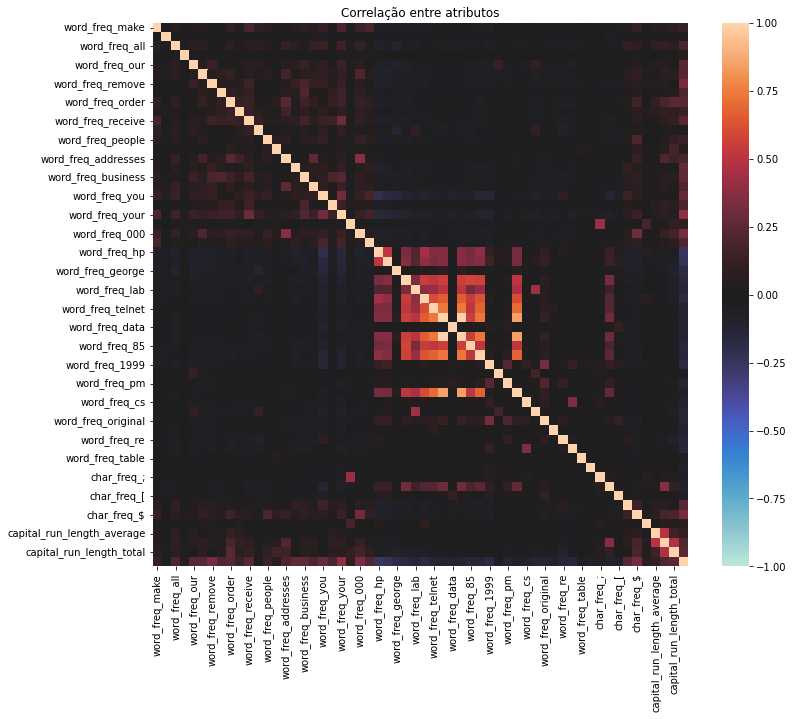

In [18]:
# Checando a correlação

features = df.columns
plt.figure(figsize=[12,10])
plt.title('Correlação entre atributos')
sns.heatmap(df[features].corr(), vmin=-1, vmax=1, center=0) #, 
plt.show()

**Info:** \
Parece haver uma forte multicolinearidade no conjunto de dados.

Vamos verificar com diferentes técnicas se podemos melhorar o desempenho do modelo executando etapas de extração/seleção de atributos para tratar das multicolinearidades.

**Estratégia:** \
Podemos corrigir essa multicolinearidade com as técnicas:
1. Método Manual - Fator de Inflação de Variação (VIF)
2. Método Automático - Eliminação de Recurso Recursivo (RFE)
3. Método de Decomposição - Análise de Componentes Principais (PCA)

## 5a. Método manual - VIF

O fator de inflação da variância é uma medida para o aumento da variância das estimativas dos parâmetros se uma variável adicional, for adicionada à regressão linear. É uma medida de multicolinearidade da matriz de atributos.

Uma recomendação é que se VIF for maior que 5, então a variável explicativa dada por um atributo específco é altamente **colinear** com as outras variáveis explicativas, e as estimativas dos parâmetros terão grandes erros padrão por causa disso.

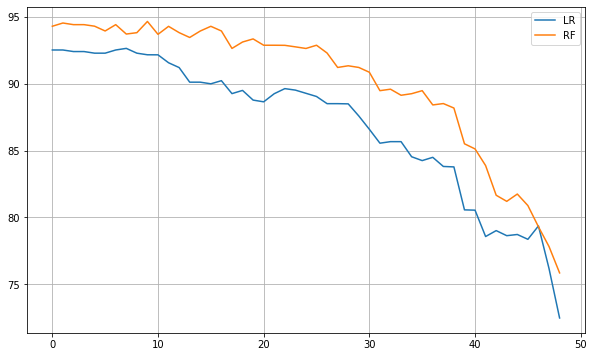

In [19]:
# Calcular os VIFs para remover a multicolinearidade

DROP=[]; scores1=[]; scores2=[];

scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        
for i in range(len(X.columns.values)-1):
    vif = pd.DataFrame()
    Xs = X.drop(DROP,axis=1)
    #print(DROP)
    vif['Atributos'] = Xs.columns
    vif['VIF'] = [variance_inflation_factor(Xs.values, i) for i in range(Xs.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    DROP.append(vif.Atributos[0])
    if vif.VIF[0]>1:
        scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
        scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std.drop(DROP,axis=1), Train_Y).predict(Test_X_std.drop(DROP,axis=1)),average='weighted')*100)
    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')

#plt.ylim([0.7,0.85])
plt.legend()
plt.grid()
plt.show()

## 5b. Método automático - RFE

Dado um estimador externo que atribui pesos aos atributos (por exemplo, os coeficientes de um modelo linear), o objetivo da eliminação recursiva de recursos (RFE) é selecionar atributos considerando, recursivamente, conjuntos cada vez menores de atributos. 

Primeiro, o estimador é treinado no conjunto inicial de características e a importância de cada característica é obtida através de qualquer atributo específico.

Em seguida, os atributos menos importantes são removidos do conjunto atual de atributos. Esse procedimento é repetido recursivamente no conjunto "podado" até que o número desejado de características a serem selecionadas seja finalmente alcançado.

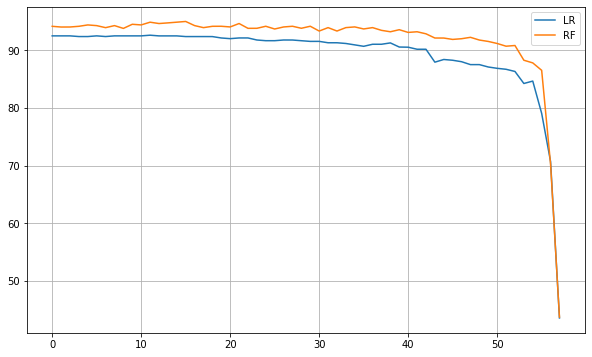

In [20]:
# Aplicando Eliminação de Atributos Recursivo

# Executando RFE com o número de saída da variável igual a 10

LR = LogisticRegression()#.fit(Train_X_std, Train_Y)

scores1=[]; scores2=[];

scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std, Train_Y).predict(Test_X_std),average='weighted')*100)
scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std, Train_Y).predict(Test_X_std),average='weighted')*100)

for i in range(len(X.columns.values)):
    rfe = RFE(LR,n_features_to_select=len(Train_X_std.columns)-i)   
    rfe = rfe.fit(Train_X_std, Train_Y)
    scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std[Train_X_std.columns[rfe.support_]], Train_Y).predict(Test_X_std[Train_X_std.columns[rfe.support_]]),average='weighted')*100)
    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')


plt.legend()
plt.grid()
plt.show()

## 5c. Análise de Componentes Principais - PCA

Redução de dimensionalidade linear usando Decomposição de Valor Singular (SVD) dos dados para projetá-lo para um espaço dimensional inferior. Os dados de entrada são centralizados, mas não dimensionados para cada atributo antes de aplicar o SVD.

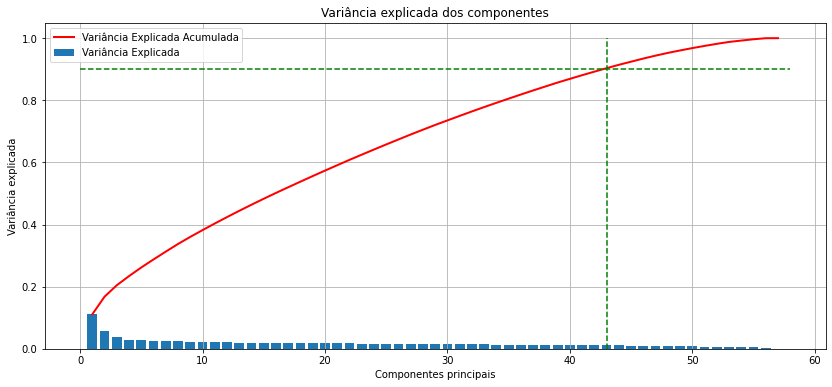

In [21]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(14,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Variância Explicada')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Variância Explicada Acumulada', color='red')
plt.plot([0,pca.n_components_+1],[0.90,0.90],'g--')
plt.plot([43,43],[0,1], 'g--')
ax.set_title('Variância explicada dos componentes')
ax.set_xlabel('Componentes principais')
ax.set_ylabel('Variância explicada')
plt.grid()
plt.legend()
plt.show()

**Info:** Devemos evitar a redução de dimensionalidade agressiva para o problema atual.

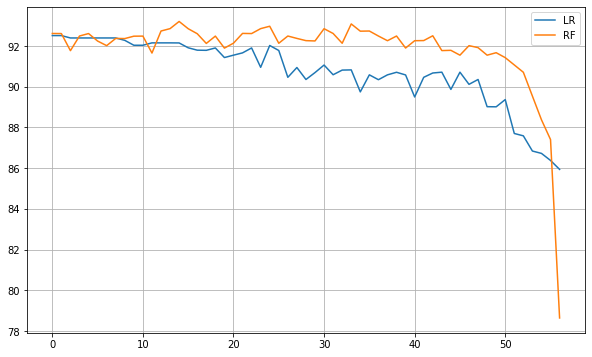

In [22]:
# Aplicando Transformações - PCA

scores1=[]; scores2=[]; 

for i in range(len(X.columns.values)):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    
    Train_X_std_pca = pd.DataFrame(Train_X_std_pca)

    Test_X_std_pca = pca.transform(Test_X_std)
    Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
    
    scores1.append(f1_score(Test_Y,LogisticRegression().fit(Train_X_std_pca, Train_Y).predict(Test_X_std_pca),average='weighted')*100)
    scores2.append(f1_score(Test_Y,RandomForestClassifier().fit(Train_X_std_pca, Train_Y).predict(Test_X_std_pca),average='weighted')*100)
    
    
plt.plot(scores1, label='LR')
plt.plot(scores2, label='RF')


plt.legend()
plt.grid()
plt.show()

**Info:** nas técnicas VIF, RFE e PCA, notamos pontuações melhores ao descartar alguns atributos multicolineares. 

Para evitar a "maldição da dimensionalidade", podemos capturar 80-90% da variação de dados explicada pelos principais n componentes do PCA.

In [23]:
# Aplicando as transformações via PCA 

pca = PCA(n_components=43)

Train_X_std_pca = pca.fit_transform(Train_X_std)
print('Shape do conjunto de treinamento transformado:')
print(Train_X_std_pca.shape)
Train_X_std_pca = pd.DataFrame(Train_X_std_pca)

Test_X_std_pca = pca.transform(Test_X_std)
print('\nShape do conjunto de teste transformado:')
print(Test_X_std_pca.shape)
Test_X_std_pca = pd.DataFrame(Test_X_std_pca)

Shape do conjunto de treinamento transformado:
(3368, 43)

Shape do conjunto de teste transformado:
(842, 43)


---

# <center> 6. Predição

**Info:** Como percebemos que os extratores/seletores de atributos não tiveram resultados tão expressivos, testaremos o treinamento e teste dos modelos com todos os atributos do banco de dados.

In [24]:
# Vamos criar primeiro uma tabela para armazenar os resultados de vários modelos

Evaluation_Results = pd.DataFrame(np.zeros((6,5)), \
                                  columns=['Accuracy', 'Precision','Recall',\
                                           'F1-score','AUC-ROC score'])

Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)',\
                          'Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)',\
                         'Support Vector Machine (SVM)','K Nearest Neighbours (KNN)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0
Support Vector Machine (SVM),0.0,0.0,0.0,0.0,0.0
K Nearest Neighbours (KNN),0.0,0.0,0.0,0.0,0.0


In [25]:
# Vamos definir funções para resumir as pontuações das previsões .

def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred_prob[:,1], multi_class='ovr'),3)*100 #[:, 1]
    print('{}{}\033[1m Avaliando {} \033[0m{}{}\n'.format('<'*3,'-'*3,Evaluation_Results.index[i], '-'*3,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100)) #
    print('\n \033[1mConfusuion Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob, curves=['each_class'])    
    plt.show()


---

## 1. Logistic Regression:

<<<--- Avaliando Logistic Regression (LR) --->>>

Accuracy = 92.60000000000001%
F1 Score = 92.60000000000001%

 Confusuion Matrix:
 [[466  29]
 [ 33 314]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       495
           1       0.92      0.90      0.91       347

    accuracy                           0.93       842
   macro avg       0.92      0.92      0.92       842
weighted avg       0.93      0.93      0.93       842



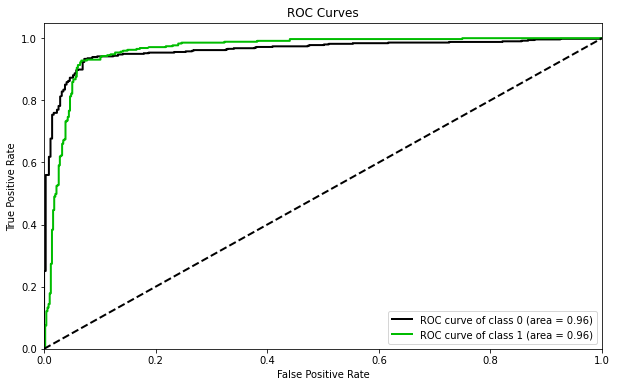


Interpretando a saída da RL:

intercept  -3.528858961403424
classes [0 1]


,coeff
word_freq_make,-0.036780
word_freq_address,0.010982
word_freq_all,-0.020938
word_freq_3d,2.660397
word_freq_our,0.350040
word_freq_over,0.166294
word_freq_remove,1.078591
word_freq_internet,0.192332
word_freq_order,0.112350
word_freq_mail,0.065114


In [26]:
LR_model = LogisticRegression()

space = dict()
space['solver'] = ['newton-cg', 'liblinear'] # 'lbfgs',
space['penalty'] = ['l2'] #'none','l1','elasticnet'
space['C'] = loguniform(1e-5, 100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(LR_model, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

LR = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = LR.predict(Test_X_std)
pred_prob = LR.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,0)

print('\n\033[1mInterpretando a saída da RL:\n\033[0m')

print('intercept ', LR.intercept_[0])
print('classes', LR.classes_)
display(pd.DataFrame({'coeff': LR.coef_[0]}, index=Train_X_std.columns))

---

## 2. Decisoin Tree Classfier:

<<<--- Avaliando Decision Tree Classifier (DT) --->>>

Accuracy = 90.0%
F1 Score = 90.10000000000001%

 Confusuion Matrix:
 [[445  50]
 [ 34 313]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91       495
           1       0.86      0.90      0.88       347

    accuracy                           0.90       842
   macro avg       0.90      0.90      0.90       842
weighted avg       0.90      0.90      0.90       842



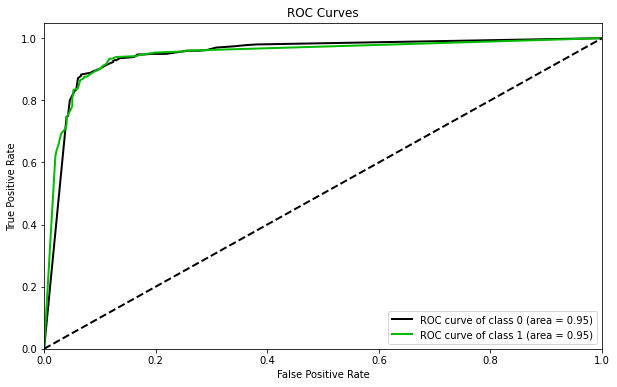


Interrpretando a saída da DT:



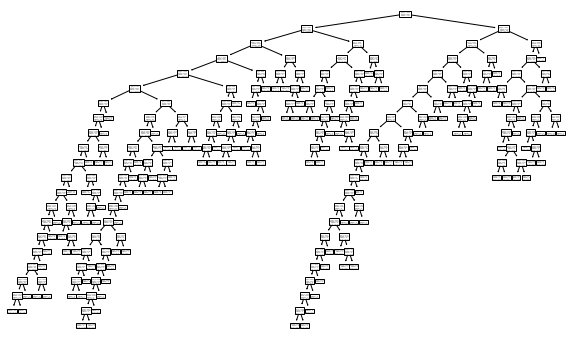

In [27]:
DT_model = DecisionTreeClassifier()

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(DT_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

DT = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = DT.predict(Test_X_std)
pred_prob = DT.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,1)

print('\n\033[1mInterrpretando a saída da DT:\n\033[0m')
tree.plot_tree(DT)
plt.show()

---

## 3. Random Forest Classfier:

<<<--- Avaliando Random Forest Classifier (RF) --->>>

Accuracy = 93.89999999999999%
F1 Score = 93.89999999999999%

 Confusuion Matrix:
 [[475  20]
 [ 31 316]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       495
           1       0.94      0.91      0.93       347

    accuracy                           0.94       842
   macro avg       0.94      0.94      0.94       842
weighted avg       0.94      0.94      0.94       842



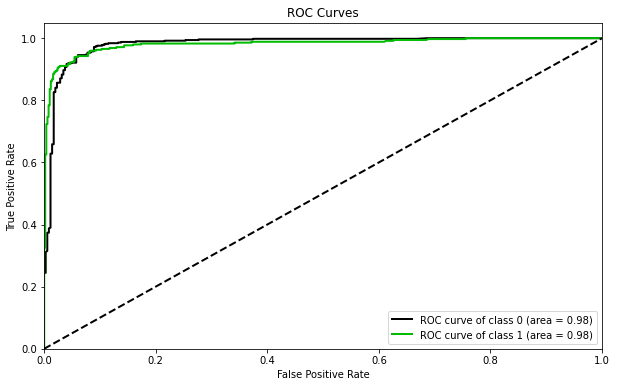


Interrpretando a saída da RF:



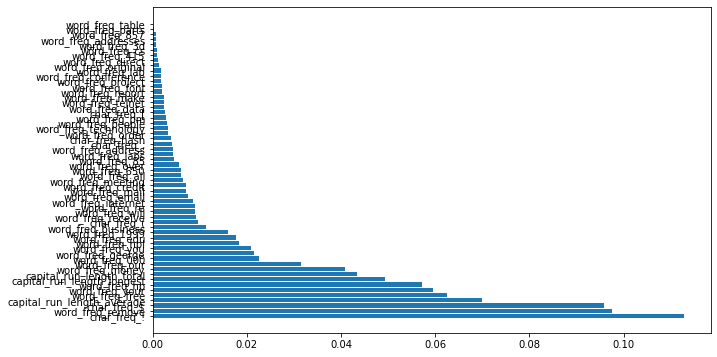

In [28]:
RF_model = RandomForestClassifier()

param_dist={'bootstrap': [True, False],
            'max_depth': [10, 20, 50, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [50, 100]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(RF_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

RF = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = RF.predict(Test_X_std)
pred_prob = RF.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,2)

print('\n\033[1mInterrpretando a saída da RF:\n\033[0m')
rfi=pd.Series(RF.feature_importances_, index=Train_X_std.columns).sort_values(ascending=False)
plt.barh(rfi.index,rfi.values)
plt.show()

---

## 4. Naive Bayes Classfier:

<<<--- Avaliando Naïve Bayes Classifier (NB) --->>>

Accuracy = 90.3%
F1 Score = 90.2%

 Confusuion Matrix:
 [[459  36]
 [ 46 301]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       495
           1       0.89      0.87      0.88       347

    accuracy                           0.90       842
   macro avg       0.90      0.90      0.90       842
weighted avg       0.90      0.90      0.90       842



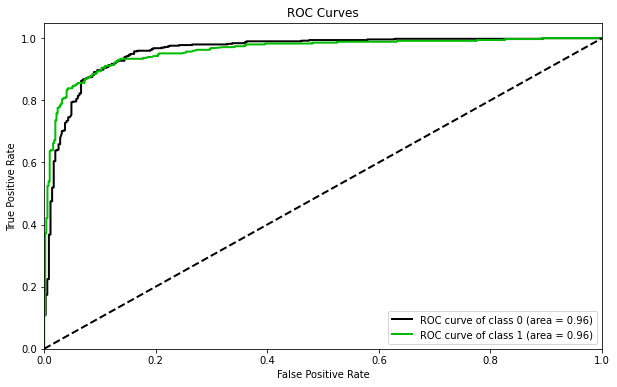

In [29]:
NB_model = BernoulliNB()

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(NB_model, params, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

NB = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = NB.predict(Test_X_std)
pred_prob = NB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,3)

---

## 5. Support Vector Machine Classfier:

<<<--- Avaliando Support Vector Machine (SVM) --->>>

Accuracy = 92.5%
F1 Score = 92.5%

 Confusuion Matrix:
 [[467  28]
 [ 35 312]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       495
           1       0.92      0.90      0.91       347

    accuracy                           0.93       842
   macro avg       0.92      0.92      0.92       842
weighted avg       0.93      0.93      0.93       842



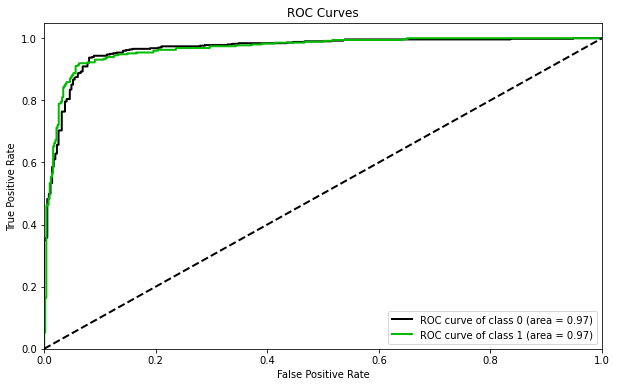

In [30]:
SVM_model = SVC(probability=True).fit(Train_X_std, Train_Y)

svm_param = {"C": [.01, .1, 1, 5, 10, 100],             
             "gamma": [.01, .1, 1, 5, 10, 100],
             "kernel": ["rbf"],
             "random_state": [1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(SVM_model, svm_param, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

SVM = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = SVM.predict(Test_X_std)
pred_prob = SVM.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,4)

---

## 6. K-Nearest Neighbours Classfier:

<<<--- Avaliando K Nearest Neighbours (KNN) --->>>

Accuracy = 91.60000000000001%
F1 Score = 91.5%

 Confusuion Matrix:
 [[482  13]
 [ 58 289]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       495
           1       0.96      0.83      0.89       347

    accuracy                           0.92       842
   macro avg       0.92      0.90      0.91       842
weighted avg       0.92      0.92      0.91       842



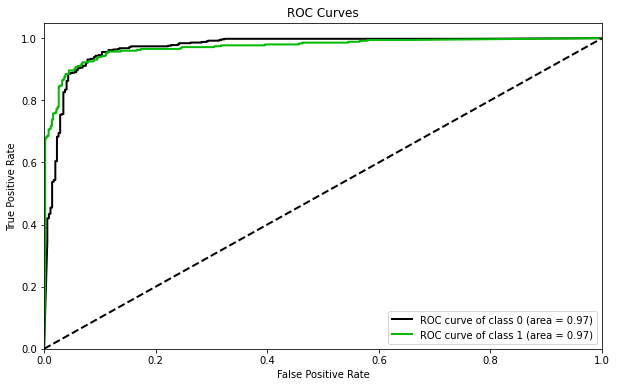

In [31]:
KNN_model = KNeighborsClassifier()

knn_param = {"n_neighbors": [i for i in range(1,30,5)],
             "weights": ["uniform", "distance"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "leaf_size": [1, 10, 30],
             "p": [1,2]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(KNN_model, knn_param, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

KNN = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = KNN.predict(Test_X_std)
pred_prob = KNN.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,5)

---

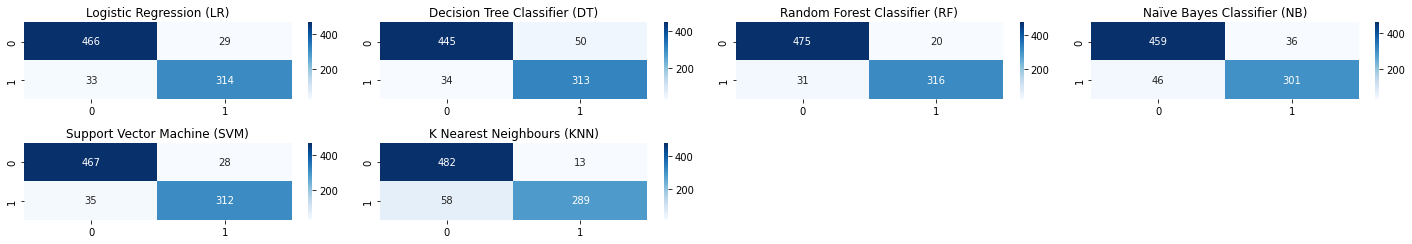

In [32]:
# Plotagem de matriz de confusão de todos os modelos preditivos

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Atual'
    cm.columns.name = 'Predito'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"
    
def conf_mat_plot(all_models):
    plt.figure(figsize=[20,3.5*math.ceil(len(all_models)*len(labels)/14)])
    
    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(2,4,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/3),3,i+1)
        pred = all_models[i].predict(Test_X_std)
        #plot_cm(Test_Y, pred)
        sns.heatmap(confusion_matrix(Test_Y, pred), annot=True, cmap='Blues', fmt='.0f') #vmin=0,vmax=5
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([LR,DT,RF,NB,SVM,KNN])

                                Comparação dos algoritmos de ML                                 


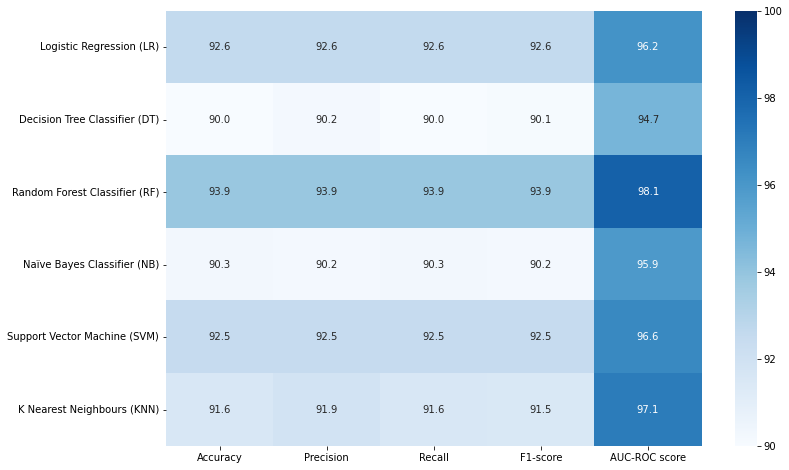

In [33]:
print('\033[1mComparação dos algoritmos de ML'.center(100))
plt.figure(figsize=[12,8])
sns.heatmap(Evaluation_Results, annot=True, vmin=90, vmax=100, cmap='Blues', fmt='.1f')
plt.show()

**Insights:** de acordo com o problema atual, é mais importante focar na métrica Precisão. Podemos observar no mapa de calor acima que os modelos Random Forest & Logistic Regression tiveram um bom desempenho no conjunto de dados atual.

---

### Principais resultados e análises:
- O conjunto de dados é pequeno, totalizando cerca de 4600 amostras e após o pré-processamento e separação dos dados, amostras de dados foram descartadas e ficamos com 3368 para treinar.
- As amostras ficaram ligeiramente desequilibradas após o processamento, portanto, a técnica SMOTE foi aplicada nos dados de **treinamento** para balancear as classes, adicionando 17,3% mais amostras ao conjunto de dados.
- A visualização da distribuição de dados e seus relacionamentos nos ajudou a obter alguns insights sobre o relacionamento entre o conjunto de atributos.
- Testar vários algoritmos com hiperparâmetros ajustados nos deu alguma compreensão sobre o desempenho do modelo neste conjunto de dados específico.
- O classificador Random Forest e o classificador Logistic Regression tiveram desempenho excepcional no conjunto de dados atual, considerando a Precisão como a métrica chave.
- No entanto, é aconselhável considerar também um modelo mais simples, como a regressão logística, pois é mais generalizável e é computacionalmente mais barato, mas tem o custo de pequenos erros de classificação.

**A Fazer:** 
- A seleção/extração de atributos foi demonstrada com 3 técnicas, resta treinar os modelos com os atributos que foram pré-selecionados.